In [1]:
!pip install kaggle

In [2]:
# Configuring Kaggle API access:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


### Importing twitter sentiment dataset

In [3]:
# Download the Sentiment140 dataset from Kaggle using the API
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
100% 80.9M/80.9M [00:05<00:00, 21.8MB/s]
100% 80.9M/80.9M [00:05<00:00, 16.1MB/s]


In [4]:
# Extract the zip file
from zipfile import ZipFile

dataset = '/content/sentiment140.zip'
with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print('The dataset is extracted')


The dataset is extracted


In [25]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score




In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# Print the list of stopwords in English (common words that don't add significant meaning to the text)
print(stopwords.words('english'))
# Stopwords are common words (like 'the', 'is', 'in') that don't carry much emotional or informational weight,
# which is why we should remove them from the text during preprocessing.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
# Load the dataset from a CSV file into a pandas DataFrame
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [9]:
# Get the number of rows and columns in the dataset
twitter_data.shape

(1599999, 6)

In [10]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [11]:
# Define column names for the dataset and load it again with these new names
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=column_names)


In [12]:
twitter_data.shape

(1600000, 6)

In [13]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
# Get the number of missing (null) values in each column of the dataset
twitter_data.isnull().sum()


,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [15]:
# checkiing the  distrubtion of target columns
twitter_data['target'].value_counts()

# O : the tweet is negative
# 4 : the tweet is  positive

,count
target,
0,800000
4,800000


In [16]:
# Convert the label '4' in the 'target' column to '1'
twitter_data.replace({'target': {4:1}}, inplace=True)
# inplace=True means the modification will be directly applied to the original DataFrame, without creating a copy


In [17]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


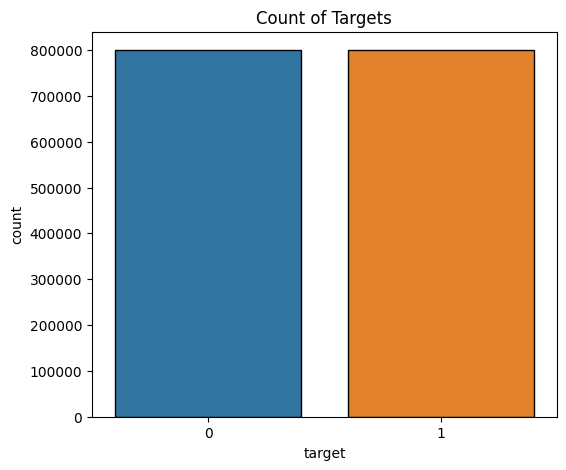

In [57]:
plt.figure(figsize=(6, 5))
sns.countplot(x='target', data=twitter_data, hue='target', palette=['#1f77b4', '#ff7f0e'], edgecolor='black', legend=False)
plt.title('Count of Targets')  # Add your title here
plt.show()


In [18]:
# Stemming
# ---> Stemming is the process of reducing a word to its root or base form (e.g., "actor", "actress", "acting" -> "act")
# This helps reduce the dimensionality and complexity of the data, making it easier for the model to process and perform operations efficiently.


In [19]:
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [20]:
# Apply this function to the data that we have
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [21]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [22]:
print(twitter_data['stemmed_content'])
print(twitter_data['target'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object
0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [26]:
# Separate the data (features) and labels (target) for model training
x = twitter_data['stemmed_content'].values  # Features (input data)
y = twitter_data['target'].values            # Labels (output data)


In [27]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=2)
# stratify=y ensures that the proportion of classes in the target variable is maintained in both training and testing sets
# random_state=2 ensures reproducibility, so the data is split in the same way every time the code is run


In [28]:
print(x.shape ,x_train.shape ,x_test.shape )

(1600000,) (1280000,) (320000,)


In [29]:
# Convert text to numerical values using TF-IDF (Term Frequency-Inverse Document Frequency)
# Each word is assigned a numerical value based on its frequency and importance in the text
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)  # Fit the vectorizer on the training data

# Transform both training and testing data into numerical format
x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)


In [60]:
print(x_train)
print(x_test)

  (0, 109306)	0.37537085874022996
  (0, 185193)	0.527767906057601
  (0, 235045)	0.41996827700291106
  (0, 354543)	0.3588091611460022
  (0, 436713)	0.27259876264838384
  (0, 443066)	0.44847553170231724
  (1, 160636)	1.0
  (2, 77929)	0.3128408075034635
  (2, 109306)	0.45911764137283173
  (2, 124484)	0.18921559608014152
  (2, 129411)	0.2907419272795715
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.1880385058320795
  (2, 178061)	0.1619010109445149
  (2, 266729)	0.24123230668976978
  (2, 288470)	0.16786949597862735
  (2, 406399)	0.32105459490875526
  (2, 407301)	0.18709338684973031
  (2, 409143)	0.15169282335109838
  (2, 433560)	0.32965958980285653
  (2, 443430)	0.33485996702528453
  (3, 56476)	0.5200465453608686
  (3, 151770)	0.278559647704793
  (3, 158711)	0.44569393722995737
  (3, 172421)	0.37464146922154384
  :	:
  (1279996, 291078)	0.17981734369155505
  (1279996, 318303)	0.21254698865277746
  (1279996, 373144)	0.3521250099983204
  (1279996, 390130)	0.2206474219107611
  (1279996, 412

In [31]:
# Train the machine learning model using Logistic Regression
model = LogisticRegression(max_iter=1000)  # Initialize the model with a maximum of 1000 iterations
model.fit(x_train, y_train)  # Fit the model to the training data


LogisticRegression(max_iter=1000)

In [61]:
x_tain_prediction = model.predict(x_train)
training_data_accuracy = accuracy_score(y_train , x_tain_prediction )
print('Accuracy on training data : ', training_data_accuracy)

Accuracy on training data :  0.79871953125


In [62]:
# Make predictions on the test data using the trained model
x_test_prediction = model.predict(x_test)

# Calculate the accuracy of the model on the test data
test_data_accuracy = accuracy_score(y_test, x_test_prediction)
print('Accuracy on test data: ', test_data_accuracy)

# Overfitting occurs when there is a significant gap between training accuracy and test accuracy
# This indicates that the model is performing well on the training data but poorly on unseen data



Accuracy on test data:  0.77668125


In [34]:
# Save the moel
import pickle
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [35]:
# make new prediction
# loading the saved model
loaded_model = pickle.load(open('trained_model.sav', 'rb'))


In [65]:
# Predict the sentiment of a new instance from the test data
x_new = x_test[200]  # Select a sample from the test set
print(y_test[200])  # Display the selected sample

prediction = loaded_model.predict(x_new)
print(prediction)
if prediction[0] == 0:
  print('Negative')
else:
  print('Positive')

print(prediction)

1
[1]
Positive
[1]


In [67]:
# Predict the sentiment of a new instance from the test data
x_new = x_test[3]  # Select a sample from the test set
print(y_test[3])  # Display the selected sample

prediction = loaded_model.predict(x_new)
if prediction[0] == 0:
  print('Negative')
else:
  print('Positive')

print(prediction)

0
Negative
[0]
